# 1. 安装数据包

In [1]:
# 数据分析的核心库

import sys
import math
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
from pandas.plotting import lag_plot
from pandas import datetime
import random
# 时间序列处理
from datetime import datetime
from dateutil.parser import parse as dt_parse
# 正则库
import re
# os库
from os import listdir
# NLTK自然语言处理库
import nltk
#nltk.download('stopwords')
#nltk.download('punkt')
from nltk.corpus import stopwords
# seaborn成对图矩阵生成
from seaborn import pairplot
# sklearn库的归一化、训练集测试集划分
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
# Keras LSTM
import tensorflow 
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Layer
from tensorflow.keras import Model, layers, initializers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import MaxPooling1D, Flatten, Activation, GRU
from tensorflow.keras.layers import Multiply, Input,Dense, Dropout, Conv1D, LSTM, Bidirectional, TimeDistributed
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.callbacks import EarlyStopping
# ARIMA 
import statsmodels.api as sm
import statsmodels.tsa as ts
from statsmodels.tsa.arima_model import ARIMAResults
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import r2_score
from sklearn.metrics import explained_variance_score
import itertools as it
#from tensorflow.keras.regularizers import L1, L2
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.metrics import RootMeanSquaredError
# sklearn MSE
from sklearn import metrics
from sklearn.metrics import mean_squared_error
# GridSearchCV
from sklearn.model_selection import GridSearchCV

import os
 
os.environ["PATH"] += os.pathsep + 'C:/Users/Administrator/Thesis Programming/情感数据对股票模型预测的影响及神经网络设计/file'

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  # This is added back by InteractiveShellApp.init_path()


# 2. Pandas 显示设置

In [2]:
# 设置pandas的最大显示行数、列数和输出宽度
pd.set_option('display.max_rows', 30)
pd.set_option('display.max_columns', 999)
pd.set_option('display.max_colwidth', 50)

# 3. 特征工程-模型预处理
## 创建结构化调用函数

In [3]:
#时间序列转有监督函数定义
def series_to_supervised(data, n_in=1):
    # 默认参数
    n_out=1
    dropnan=True
    # 对该函数进行微调，注意data为以close列（需要预测的列）结尾的DataFrame时间序列股票数据
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # 删除无关的次态[t]列，只留下需要预测的close[t]列和上一时刻状态特征[t-1]列
    agg.drop(agg.columns[[x for x in range(data.shape[1], 2*data.shape[1]-1)]], axis=1, inplace=True)
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [4]:
# 损失图绘制
def drawLossGraph(_history, title, num):
    
    #损失图绘制，观察最优epochs
    #:param _history: 训练历史
    #:param title: 图表标题
    #:param num: 图表编号
    #:return: 无
    
    plt.plot(_history.history['loss'], color='g', label='train')
    plt.plot(_history.history['val_loss'], color='r', label='test')
    plt.title('Fig'+num+'. '+title)
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.legend()
    # 保存于 new_test_file/result/
    savingPath = 'file/Fig'+num+'_'+title.replace(' ', '_')+'.png'
    plt.savefig(savingPath, dpi=400, bbox_inches='tight')
    # 展示
    plt.show()

In [5]:
# 定义反归一化函数
def inverse_transform_col(_scaler, y, n_col):
    """
    对某个列进行反归一化处理的函数
    :param _scaler: sklearn归一化模型
    :param y: 需要反归一化的数据列
    :param n_col: y在归一化时所属的列编号
    :return: y的反归一化结果
    """
    y = y.copy()
    y -= _scaler.min_[n_col]
    y /= _scaler.scale_[n_col]
    return y

In [6]:
# 模型预测结果绘图函数
def predictGraph(yTrain, yPredict, yTest, timelabels, title, num):
    """
    预测结果图像绘制函数
    :param yTrain: 训练集结果
    :param yPredict: 验证集的预测结果
    :param yTest: 验证集的真实结果
    :param timelabels: x轴刻度标签
    :param title: 图表标题
    :param num: 图标编号
    :return: 无
    """
    len_yTrain = yTrain.shape[0]
    len_y = len_yTrain+yPredict.shape[0]
    # 真实曲线绘制
    plt.plot(np.concatenate([yTrain,yTest]), color='r', label='sample')
    # 预测曲线绘制
    plt.plot([x for x in range(len_yTrain,len_y)],yPredict, color='g', label='predict')
    # 标题和轴标签
    plt.title('Fig'+num+'. '+title)
    plt.xlabel('date')
    plt.ylabel('close')
    plt.legend()
    # 刻度和刻度标签
    xticks = [0,len_yTrain,len_y-1]
    xtick_labels = [timelabels[x] for x in xticks]
    plt.xticks(ticks=xticks, labels=xtick_labels, rotation=30)
    # 保存于 new_test_file/result/
    savingPath = 'file/Fig'+num+'_'+title.replace(' ', '_')+'.png'
    plt.savefig(savingPath, dpi=400, bbox_inches='tight')
    # 展示
    plt.show()

# 4. 循环网络的搭建

## 4.1 (一年数据) 情感数据CNN_BILSTM_AT v.s. 纯技术指标CNN_BILSTM_AT

### （一年）情感数据影响下的CNN_BILSTM_AT

In [7]:
# 读取数据
CBA1Emo = pd.read_csv('file/one_year/one_result/TSLA_stockwithEmo_1Y.csv', parse_dates=['Date'], index_col='Date').values
CBA1Emo

array([[3.16843323e+02, 3.48339996e+02, 3.14733337e+02, ...,
        4.88038517e-02, 7.20361750e-02, 3.41619995e+02],
       [3.41563324e+02, 3.64980011e+02, 3.33813324e+02, ...,
        7.68664389e-02, 8.51711347e-02, 3.39476654e+02],
       [3.46553345e+02, 3.56959991e+02, 3.43593323e+02, ...,
        5.11512681e-02, 8.35095523e-02, 3.45953339e+02],
       ...,
       [2.29500000e+02, 2.29820007e+02, 2.17250000e+02, ...,
        6.25000000e-02, 1.60282258e-01, 2.20190002e+02],
       [2.19800003e+02, 2.22929993e+02, 2.17779999e+02, ...,
        1.42857143e-02, 9.02331002e-02, 2.22039993e+02],
       [2.08279999e+02, 2.15550003e+02, 2.02000000e+02, ...,
        6.95105820e-02, 5.45836710e-02, 2.07279999e+02]])

In [8]:
# 生成归一化容器
# feature_range参数沿用默认(0,1)
scaler_CBA1Emo = MinMaxScaler(feature_range=(0,1))
# 训练模型
scaler_CBA1Emo = scaler_CBA1Emo.fit(CBA1Emo)
# 归一化
CBA1Emo = scaler_CBA1Emo.fit_transform(CBA1Emo)
# 使用series_to_supervised函数构建有监督数据集
CBA1Emo = series_to_supervised(CBA1Emo)
# 必须规定ndarray的dtype为float32（默认float64），否则后续输入模型报错
CBA1Emo = CBA1Emo.values.astype(np.float32)

In [9]:
future_days = 0
y = CBA1Emo[future_days:, 6]
print(y.shape)
X = CBA1Emo[:len(CBA1Emo) - future_days, :]
print(X.shape)

(179,)
(179, 8)


In [10]:
#time_steps = 10
time_steps = 5
X_new = np.zeros((X.shape[0] - time_steps + 1, time_steps, X.shape[1]))
y_new = np.zeros((y.shape[0] - time_steps + 1, 1))
for ix in range(X_new.shape[0]):
    for jx in range(time_steps):
        X_new[ix, jx, :] = X[ix + jx, :]
    y_new[ix] = y[ix + time_steps -1]
print(X_new.shape, y_new.shape)

(175, 5, 8) (175, 1)


In [11]:
#划分训练集和测试集 7:3
split = int(0.7 * CBA1Emo.shape[0])
X_train_CBA1Emo = X_new[:split]
X_test_CBA1Emo = X_new[split:]

y_train_CBA1Emo = y_new[:split]
y_test_CBA1Emo = y_new[split:]

print(X_train_CBA1Emo.shape, y_train_CBA1Emo.shape)
print(X_test_CBA1Emo.shape, y_test_CBA1Emo.shape)
print(X_train_CBA1Emo.shape[1], X_train_CBA1Emo.shape[2])

(125, 5, 8) (125, 1)
(50, 5, 8) (50, 1)
5 8


In [12]:
def CNN_BILSTM_AT_Generator(Xtrain, Xtest, ytrain, ytest):
  
   # 搭建模型
    inputs = Input(shape = (Xtrain.shape[1], Xtrain.shape[2]))   
    x = Conv1D(filters = 64, kernel_size = 3, activation = 'relu', padding="same")(inputs)
    #x = MaxPooling1D(pool_size = 2)(x)
    x = Dropout(0.2)(x)
    x = Bidirectional(LSTM(64, return_sequences=True,activation='relu'),name='bilstm')(x)
    previous_out = Dropout(0.2)(x)
    
    # ATTENTION PART STARTS HERE
    attention_probs = Dense(128, activation='sigmoid', name='attention_vec')(previous_out)

    attention_mul =Multiply()([previous_out, attention_probs])
    
    attention_mul = Flatten()(attention_mul)

    output = Dense(1, activation='sigmoid')(attention_mul)
    _model = Model(inputs=inputs, outputs=output)
    
    # 模型编译
    _model.compile(loss='mse', optimizer='adam', metrics=['acc', 'mae'])
    # 模型训练
    es_cb = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')
    _history = _model.fit(Xtrain, ytrain, batch_size=20, epochs=50, validation_data=(Xtest, ytest), callbacks=[es_cb], verbose=2)
    return _history,_model
  
history_CBA1Emo, model_CBA1Emo = CNN_BILSTM_AT_Generator(X_train_CBA1Emo, X_test_CBA1Emo, y_train_CBA1Emo, y_test_CBA1Emo)

Train on 125 samples, validate on 50 samples
Epoch 1/50
125/125 - 2s - loss: 0.0583 - acc: 0.0080 - mae: 0.2058 - val_loss: 0.0500 - val_acc: 0.0000e+00 - val_mae: 0.1767
Epoch 2/50
125/125 - 0s - loss: 0.0535 - acc: 0.0080 - mae: 0.1962 - val_loss: 0.0529 - val_acc: 0.0200 - val_mae: 0.1906
Epoch 3/50
125/125 - 0s - loss: 0.0482 - acc: 0.0080 - mae: 0.1834 - val_loss: 0.0547 - val_acc: 0.0200 - val_mae: 0.2028
Epoch 4/50
125/125 - 0s - loss: 0.0408 - acc: 0.0080 - mae: 0.1660 - val_loss: 0.0436 - val_acc: 0.0200 - val_mae: 0.1755
Epoch 5/50
125/125 - 0s - loss: 0.0316 - acc: 0.0080 - mae: 0.1448 - val_loss: 0.0290 - val_acc: 0.0200 - val_mae: 0.1284
Epoch 6/50
125/125 - 0s - loss: 0.0213 - acc: 0.0080 - mae: 0.1164 - val_loss: 0.0162 - val_acc: 0.0200 - val_mae: 0.0949
Epoch 7/50
125/125 - 0s - loss: 0.0165 - acc: 0.0080 - mae: 0.1110 - val_loss: 0.0156 - val_acc: 0.0200 - val_mae: 0.1092
Epoch 8/50
125/125 - 0s - loss: 0.0129 - acc: 0.0080 - mae: 0.0929 - val_loss: 0.0094 - val_acc: 

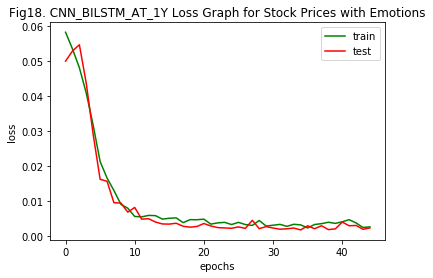

In [13]:
drawLossGraph(history_CBA1Emo, title='CNN_BILSTM_AT_1Y Loss Graph for Stock Prices with Emotions', num='18')

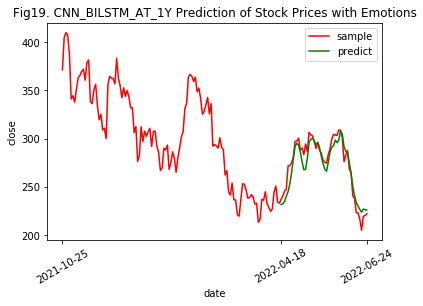

In [14]:
# 由X_test前日股票指标预测当天股票close值
# 注：predict生成的array需降维成 shape=(n_samples, )
y_predict_CBA1Emo = model_CBA1Emo.predict(X_test_CBA1Emo)[:,0]

# 反归一化
# 重新读取 TSLA股票价格融合情感.csv
CBA1Emo = pd.read_csv('file/one_year/one_result/TSLA_stockwithEmo_1Y.csv')
col_n_CBA1Emo = CBA1Emo.shape[1]-2
# 预测结果反归一化
inv_yPredict_CBA1Emo = inverse_transform_col(scaler_CBA1Emo, y_predict_CBA1Emo, col_n_CBA1Emo)
# 真实结果反归一化
inv_yTest_CBA1Emo = inverse_transform_col(scaler_CBA1Emo, y_test_CBA1Emo, col_n_CBA1Emo)
# 训练集结果反归一化（以绘制完整图像）
inv_yTrain_CBA1Emo = inverse_transform_col(scaler_CBA1Emo, y_train_CBA1Emo, col_n_CBA1Emo)
# 绘图
predictGraph(inv_yTrain_CBA1Emo, inv_yPredict_CBA1Emo, inv_yTest_CBA1Emo, timelabels = CBA1Emo['Date'].values, title='CNN_BILSTM_AT_1Y Prediction of Stock Prices with Emotions', num='19')

In [15]:
# 输出MSE MAE R方评估值
MSE_error_CBA1Emo = mean_squared_error(inv_yTest_CBA1Emo, inv_yPredict_CBA1Emo)
RMSE_CBA1Emo = math.sqrt(MSE_error_CBA1Emo)
MAE_CBA1Emo = mean_absolute_error(inv_yTest_CBA1Emo, inv_yPredict_CBA1Emo)
R_square_CBA1Emo = r2_score(inv_yTest_CBA1Emo, inv_yPredict_CBA1Emo)
print('The Mean Squared Error is {}'.format(MSE_error_CBA1Emo))
print('The Root Mean Squared Error is:')
print(RMSE_CBA1Emo)
print('The Mean Absolute Error is:',MAE_CBA1Emo)
print('R Square is {}'.format(R_square_CBA1Emo))

The Mean Squared Error is 93.9993433603801
The Root Mean Squared Error is:
9.695325851170765
The Mean Absolute Error is: 7.671987039745238
R Square is 0.8901500349506839


In [16]:
print(model_CBA1Emo.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 5, 8)]       0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 5, 64)        1600        input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 5, 64)        0           conv1d[0][0]                     
__________________________________________________________________________________________________
bilstm (Bidirectional)          (None, 5, 128)       66048       dropout[0][0]                    
______________________________________________________________________________________________

### （一年）纯技术指标影响下的CNN_BILSTM_AT

In [17]:
# 读取数据
CBA1p = pd.read_csv('file/one_year/one_result/TSLA_stockprice_1Y.csv', parse_dates=['Date'], index_col='Date').values
CBA1p

array([[3.16843323e+02, 3.48339996e+02, 3.14733337e+02, 1.88556300e+08,
        3.41619995e+02],
       [3.41563324e+02, 3.64980011e+02, 3.33813324e+02, 1.87245000e+08,
        3.39476654e+02],
       [3.46553345e+02, 3.56959991e+02, 3.43593323e+02, 1.15579500e+08,
        3.45953339e+02],
       ...,
       [2.19800003e+02, 2.22929993e+02, 2.17779999e+02, 6.65715000e+07,
        2.22039993e+02],
       [2.08279999e+02, 2.15550003e+02, 2.02000000e+02, 1.17798100e+08,
        2.07279999e+02],
       [2.06419998e+02, 2.14660004e+02, 2.03800003e+02, 7.55293000e+07,
        2.14440002e+02]])

In [18]:
# 生成归一化容器
# feature_range参数沿用默认(0,1)
scaler_CBA1p = MinMaxScaler(feature_range=(0,1))
# 训练模型
scaler_CBA1p = scaler_CBA1p.fit(CBA1p)
# 归一化
CBA1p = scaler_CBA1p.fit_transform(CBA1p)
# 使用series_to_supervised函数构建有监督数据集
CBA1p = series_to_supervised(CBA1p)
# 必须规定ndarray的dtype为float32（默认float64），否则后续输入模型报错
CBA1p = CBA1p.values.astype(np.float32)

In [19]:
future_days = 0
yy = CBA1p[future_days:, 4]
print(yy.shape)
XX = CBA1p[:len(CBA1p) - future_days, :]
print(XX.shape)

(250,)
(250, 6)


In [20]:
#time_steps = 10
time_steps = 5
XX_new = np.zeros((XX.shape[0] - time_steps + 1, time_steps, XX.shape[1]))
yy_new = np.zeros((yy.shape[0] - time_steps + 1, 1))
for ix in range(XX_new.shape[0]):
    for jx in range(time_steps):
        XX_new[ix, jx, :] = XX[ix + jx, :]
    yy_new[ix] = yy[ix + time_steps -1]
print(XX_new.shape, yy_new.shape)

(246, 5, 6) (246, 1)


In [21]:
#划分训练集和测试集 7:3
split = int(0.7 * CBA1p.shape[0])
X_train_CBA1p = XX_new[:split]
X_test_CBA1p = XX_new[split:]

y_train_CBA1p = yy_new[:split]
y_test_CBA1p = yy_new[split:]

print(X_train_CBA1p.shape, y_train_CBA1p.shape)
print(X_test_CBA1p.shape, y_test_CBA1p.shape)
print(X_train_CBA1p.shape[1], X_train_CBA1p.shape[2])

(175, 5, 6) (175, 1)
(71, 5, 6) (71, 1)
5 6


In [22]:
history_CBA1p, model_CBA1p = CNN_BILSTM_AT_Generator(X_train_CBA1p, X_test_CBA1p, y_train_CBA1p, y_test_CBA1p)

Train on 175 samples, validate on 71 samples
Epoch 1/50
175/175 - 2s - loss: 0.0566 - acc: 0.0057 - mae: 0.2006 - val_loss: 0.0585 - val_acc: 0.0141 - val_mae: 0.2048
Epoch 2/50
175/175 - 0s - loss: 0.0476 - acc: 0.0057 - mae: 0.1776 - val_loss: 0.0630 - val_acc: 0.0141 - val_mae: 0.2252
Epoch 3/50
175/175 - 0s - loss: 0.0415 - acc: 0.0057 - mae: 0.1622 - val_loss: 0.0468 - val_acc: 0.0141 - val_mae: 0.1821
Epoch 4/50
175/175 - 0s - loss: 0.0315 - acc: 0.0057 - mae: 0.1394 - val_loss: 0.0364 - val_acc: 0.0141 - val_mae: 0.1585
Epoch 5/50
175/175 - 0s - loss: 0.0229 - acc: 0.0057 - mae: 0.1238 - val_loss: 0.0213 - val_acc: 0.0141 - val_mae: 0.1133
Epoch 6/50
175/175 - 0s - loss: 0.0165 - acc: 0.0057 - mae: 0.1054 - val_loss: 0.0137 - val_acc: 0.0141 - val_mae: 0.0918
Epoch 7/50
175/175 - 0s - loss: 0.0115 - acc: 0.0057 - mae: 0.0871 - val_loss: 0.0109 - val_acc: 0.0141 - val_mae: 0.0829
Epoch 8/50
175/175 - 0s - loss: 0.0115 - acc: 0.0057 - mae: 0.0875 - val_loss: 0.0090 - val_acc: 0.01

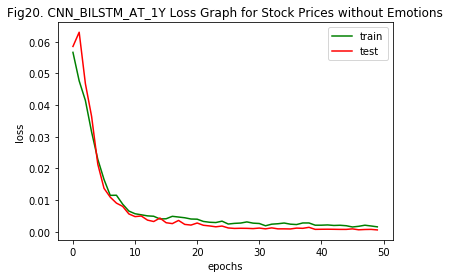

In [23]:
drawLossGraph(history_CBA1p, title='CNN_BILSTM_AT_1Y Loss Graph for Stock Prices without Emotions', num='20')

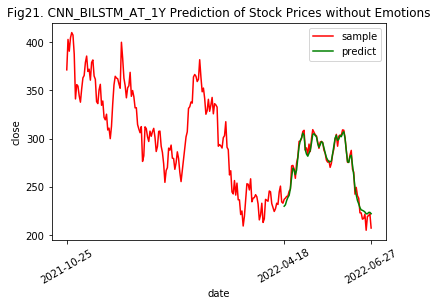

In [24]:
# 由X_test前日股票指标预测当天股票close值
# 注：predict生成的array需降维成 shape=(n_samples, )
y_predict_CBA1p = model_CBA1p.predict(X_test_CBA1p)[:,0]

# 反归一化
# 重新读取 TSLA股票价格.csv
CBA1p = pd.read_csv('file/one_year/one_result/TSLA_stockprice_1Y.csv')
col_n_CBA1p = CBA1p.shape[1]-2
# 预测结果反归一化
inv_yPredict_CBA1p = inverse_transform_col(scaler_CBA1p, y_predict_CBA1p, col_n_CBA1p)
# 真实结果反归一化
inv_yTest_CBA1p = inverse_transform_col(scaler_CBA1p, y_test_CBA1p, col_n_CBA1p)
# 训练集结果反归一化（以绘制完整图像）
inv_yTrain_CBA1p = inverse_transform_col(scaler_CBA1p, y_train_CBA1p, col_n_CBA1p)
# 绘图
predictGraph(inv_yTrain_CBA1p, inv_yPredict_CBA1p, inv_yTest_CBA1p, timelabels = CBA1p['Date'].values, title='CNN_BILSTM_AT_1Y Prediction of Stock Prices without Emotions', num='21')

In [25]:
# 输出MSE MAE R方评估值
MSE_error_CBA1p = mean_squared_error(inv_yTest_CBA1p, inv_yPredict_CBA1p)
RMSE_CBA1p = math.sqrt(MSE_error_CBA1p)
MAE_CBA1p = mean_absolute_error(inv_yTest_CBA1p, inv_yPredict_CBA1p)
R_square_CBA1p = r2_score(inv_yTest_CBA1p, inv_yPredict_CBA1p)
print('The Mean Squared Error is {}'.format(MSE_error_CBA1p))
print('The Root Mean Squared Error is:')
print(RMSE_CBA1p)
print('The Mean Absolute Error is:',MAE_CBA1p)
print('R Square is {}'.format(R_square_CBA1p))

The Mean Squared Error is 23.694624151992056
The Root Mean Squared Error is:
4.867712414676124
The Mean Absolute Error is: 3.5295316224946256
R Square is 0.9737262466821643


In [26]:
print(model_CBA1p.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 5, 6)]       0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 5, 64)        1216        input_2[0][0]                    
__________________________________________________________________________________________________
dropout_2 (Dropout)             (None, 5, 64)        0           conv1d_1[0][0]                   
__________________________________________________________________________________________________
bilstm (Bidirectional)          (None, 5, 128)       66048       dropout_2[0][0]                  
____________________________________________________________________________________________

## 4.2 (五年数据) 情感数据CNN_BILSTM_AT v.s. 纯技术指标CNN_BILSTM_AT

### （五年）情感数据影响下的CNN_BILSTM_AT

In [27]:
# 读取数据
CBA5Emo = pd.read_csv('file/five_year/five_result/TSLA_stockwithEmo_5Y.csv', parse_dates=['Date'], index_col='Date').values
CBA5Emo

array([[2.09733330e+01, 2.11320000e+01, 2.07506680e+01, ...,
        0.00000000e+00, 8.33333333e-02, 2.10086670e+01],
       [2.09753320e+01, 2.19340000e+01, 2.09166680e+01, ...,
        0.00000000e+00, 0.00000000e+00, 2.19273340e+01],
       [2.20300010e+01, 2.27626670e+01, 2.20020010e+01, ...,
        1.00000000e-01, 0.00000000e+00, 2.27353320e+01],
       ...,
       [1.90779999e+02, 1.95889999e+02, 1.77119995e+02, ...,
        2.63888889e-02, 1.08966426e-01, 1.77589996e+02],
       [1.89899994e+02, 1.91000000e+02, 1.80029999e+02, ...,
        3.01587302e-01, 8.33333333e-02, 1.90720001e+02],
       [1.86000000e+02, 1.96520004e+02, 1.82589996e+02, ...,
        7.80380334e-02, 3.33951763e-02, 1.95970001e+02]])

In [28]:
# 生成归一化容器
# feature_range参数沿用默认(0,1)
scaler_CBA5Emo = MinMaxScaler(feature_range=(0,1))
# 训练模型
scaler_CBA5Emo = scaler_CBA5Emo.fit(CBA5Emo)
# 归一化
CBA5Emo = scaler_CBA5Emo.fit_transform(CBA5Emo)
# 使用series_to_supervised函数构建有监督数据集
CBA5Emo = series_to_supervised(CBA5Emo)
# 必须规定ndarray的dtype为float32（默认float64），否则后续输入模型报错
CBA5Emo = CBA5Emo.values.astype(np.float32)

In [29]:
future_days = 0
yyy = CBA5Emo[future_days:, 6]
print(yyy.shape)
XXX = CBA5Emo[:len(CBA5Emo) - future_days, :]
print(XXX.shape)

(1240,)
(1240, 8)


In [30]:
#time_steps = 10
time_steps = 20
XXX_new = np.zeros((XXX.shape[0] - time_steps + 1, time_steps, XXX.shape[1]))
yyy_new = np.zeros((yyy.shape[0] - time_steps + 1, 1))
for ix in range(XXX_new.shape[0]):
    for jx in range(time_steps):
        XXX_new[ix, jx, :] = XXX[ix + jx, :]
    yyy_new[ix] = yyy[ix + time_steps -1]
print(XXX_new.shape, yyy_new.shape)

(1221, 20, 8) (1221, 1)


In [31]:
#划分训练集和测试集 7:3
split = int(0.7 * CBA5Emo.shape[0])
X_train_CBA5Emo = XXX_new[:split]
X_test_CBA5Emo = XXX_new[split:]

y_train_CBA5Emo = yyy_new[:split]
y_test_CBA5Emo = yyy_new[split:]

print(X_train_CBA5Emo.shape, y_train_CBA5Emo.shape)
print(X_test_CBA5Emo.shape, y_test_CBA5Emo.shape)
print(X_train_CBA5Emo.shape[1], X_train_CBA5Emo.shape[2])

(1116, 20, 8) (1116, 1)
(105, 20, 8) (105, 1)
20 8


In [32]:
def CNN_BILSTM_AT_GeneratorEX(Xtrain, Xtest, ytrain, ytest):
  
   # 搭建模型
    inputs = Input(shape = (Xtrain.shape[1], Xtrain.shape[2]))   
    x = Conv1D(filters = 64, kernel_size = 3, activation = 'relu', padding="same")(inputs)
    #x = MaxPooling1D(pool_size = 2)(x)
    x = Dropout(0.2)(x)
    x = Bidirectional(LSTM(64, return_sequences=True,activation='relu'),name='bilstm')(x)
    previous_out = Dropout(0.2)(x)
    
    # ATTENTION PART STARTS HERE
    attention_probs = Dense(128, activation='sigmoid', name='attention_vec')(previous_out)

    attention_mul =Multiply()([previous_out, attention_probs])
    
    attention_mul = Flatten()(attention_mul)

    output = Dense(1, activation='sigmoid')(attention_mul)
    _model = Model(inputs=inputs, outputs=output)
    
    # 模型编译
    _model.compile(loss='mse', optimizer='adam', metrics=['acc', 'mae'])
    # 模型训练
    es_cb = EarlyStopping(monitor='val_loss', patience=13, verbose=1, mode='auto')
    _history = _model.fit(Xtrain, ytrain, batch_size=40, epochs=150, validation_data=(Xtest, ytest), callbacks=[es_cb], verbose=2)
    return _history,_model
  
history_CBA5Emo, model_CBA5Emo = CNN_BILSTM_AT_GeneratorEX(X_train_CBA5Emo, X_test_CBA5Emo, y_train_CBA5Emo, y_test_CBA5Emo)

Train on 1116 samples, validate on 105 samples
Epoch 1/150
1116/1116 - 2s - loss: 0.0672 - acc: 0.0018 - mae: 0.1984 - val_loss: 0.0046 - val_acc: 0.0000e+00 - val_mae: 0.0522
Epoch 2/150
1116/1116 - 1s - loss: 0.0043 - acc: 0.0018 - mae: 0.0452 - val_loss: 0.0041 - val_acc: 0.0000e+00 - val_mae: 0.0521
Epoch 3/150
1116/1116 - 1s - loss: 0.0023 - acc: 0.0018 - mae: 0.0317 - val_loss: 0.0051 - val_acc: 0.0000e+00 - val_mae: 0.0582
Epoch 4/150
1116/1116 - 1s - loss: 0.0016 - acc: 0.0018 - mae: 0.0250 - val_loss: 0.0064 - val_acc: 0.0000e+00 - val_mae: 0.0684
Epoch 5/150
1116/1116 - 1s - loss: 0.0014 - acc: 0.0018 - mae: 0.0234 - val_loss: 0.0020 - val_acc: 0.0000e+00 - val_mae: 0.0354
Epoch 6/150
1116/1116 - 1s - loss: 0.0014 - acc: 0.0018 - mae: 0.0231 - val_loss: 0.0022 - val_acc: 0.0000e+00 - val_mae: 0.0380
Epoch 7/150
1116/1116 - 1s - loss: 0.0015 - acc: 0.0018 - mae: 0.0241 - val_loss: 0.0031 - val_acc: 0.0000e+00 - val_mae: 0.0451
Epoch 8/150
1116/1116 - 1s - loss: 9.7902e-04 - ac

Epoch 61/150
1116/1116 - 1s - loss: 1.9636e-04 - acc: 0.0018 - mae: 0.0090 - val_loss: 2.8249e-04 - val_acc: 0.0000e+00 - val_mae: 0.0135
Epoch 62/150
1116/1116 - 1s - loss: 2.1527e-04 - acc: 0.0018 - mae: 0.0096 - val_loss: 1.8275e-04 - val_acc: 0.0000e+00 - val_mae: 0.0106
Epoch 63/150
1116/1116 - 1s - loss: 1.9899e-04 - acc: 0.0018 - mae: 0.0092 - val_loss: 2.4228e-04 - val_acc: 0.0000e+00 - val_mae: 0.0124
Epoch 64/150
1116/1116 - 1s - loss: 1.6657e-04 - acc: 0.0018 - mae: 0.0085 - val_loss: 1.8392e-04 - val_acc: 0.0000e+00 - val_mae: 0.0107
Epoch 65/150
1116/1116 - 1s - loss: 1.4776e-04 - acc: 0.0018 - mae: 0.0081 - val_loss: 1.8082e-04 - val_acc: 0.0000e+00 - val_mae: 0.0108
Epoch 66/150
1116/1116 - 1s - loss: 2.2950e-04 - acc: 0.0018 - mae: 0.0095 - val_loss: 2.7407e-04 - val_acc: 0.0000e+00 - val_mae: 0.0130
Epoch 67/150
1116/1116 - 1s - loss: 1.4835e-04 - acc: 0.0018 - mae: 0.0082 - val_loss: 1.9676e-04 - val_acc: 0.0000e+00 - val_mae: 0.0108
Epoch 68/150
1116/1116 - 1s - loss

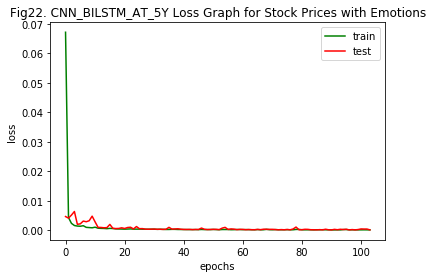

In [33]:
drawLossGraph(history_CBA5Emo, title='CNN_BILSTM_AT_5Y Loss Graph for Stock Prices with Emotions', num='22')

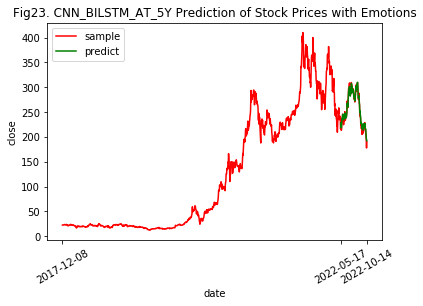

In [34]:
# 由X_test前日股票指标预测当天股票close值
# 注：predict生成的array需降维成 shape=(n_samples, )
y_predict_CBA5Emo = model_CBA5Emo.predict(X_test_CBA5Emo)[:,0]

# 反归一化
# 重新读取 TSLA股票价格融合情感.csv
CBA5Emo = pd.read_csv('file/five_year/five_result/TSLA_stockwithEmo_5Y.csv')
col_n_CBA5Emo = CBA5Emo.shape[1]-2
# 预测结果反归一化
inv_yPredict_CBA5Emo = inverse_transform_col(scaler_CBA5Emo, y_predict_CBA5Emo, col_n_CBA5Emo)
# 真实结果反归一化
inv_yTest_CBA5Emo = inverse_transform_col(scaler_CBA5Emo, y_test_CBA5Emo, col_n_CBA5Emo)
# 训练集结果反归一化（以绘制完整图像）
inv_yTrain_CBA5Emo = inverse_transform_col(scaler_CBA5Emo, y_train_CBA5Emo, col_n_CBA5Emo)
# 绘图
predictGraph(inv_yTrain_CBA5Emo, inv_yPredict_CBA5Emo, inv_yTest_CBA5Emo, timelabels = CBA5Emo['Date'].values, title='CNN_BILSTM_AT_5Y Prediction of Stock Prices with Emotions', num='23')

In [35]:
# 输出MSE MAE R方评估值
MSE_error_CBA5Emo = mean_squared_error(inv_yTest_CBA5Emo, inv_yPredict_CBA5Emo)
RMSE_CBA5Emo = math.sqrt(MSE_error_CBA5Emo)
MAE_CBA5Emo = mean_absolute_error(inv_yTest_CBA5Emo, inv_yPredict_CBA5Emo)
R_square_CBA5Emo = r2_score(inv_yTest_CBA5Emo, inv_yPredict_CBA5Emo)
print('The Mean Squared Error is {}'.format(MSE_error_CBA5Emo))
print('The Root Mean Squared Error is:')
print(RMSE_CBA5Emo)
print('The Mean Absolute Error is:',MAE_CBA5Emo)
print('R Square is {}'.format(R_square_CBA5Emo))

The Mean Squared Error is 20.038560388484836
The Root Mean Squared Error is:
4.476445061484038
The Mean Absolute Error is: 3.3805669136400804
R Square is 0.9836558894039734


In [36]:
print(model_CBA5Emo.summary())

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 20, 8)]      0                                            
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 20, 128)      3200        input_3[0][0]                    
__________________________________________________________________________________________________
dropout_4 (Dropout)             (None, 20, 128)      0           conv1d_2[0][0]                   
__________________________________________________________________________________________________
bilstm (Bidirectional)          (None, 20, 256)      263168      dropout_4[0][0]                  
____________________________________________________________________________________________

### （五年）纯技术指标下的CNN_BILSTM_AT

In [37]:
# 读取数据
CBA5p = pd.read_csv('file/five_year/five_result/TSLA_stockprice_5Y.csv', parse_dates=['Date'], index_col='Date').values
CBA5p

array([[2.35126670e+01, 2.36366670e+01, 2.29559990e+01, 7.39560000e+07,
        2.30066660e+01],
       [2.33253330e+01, 2.33300000e+01, 2.24166680e+01, 8.62095000e+07,
        2.24680000e+01],
       [2.25866660e+01, 2.28533330e+01, 2.24106670e+01, 6.73755000e+07,
        2.24893320e+01],
       ...,
       [1.90779999e+02, 1.95889999e+02, 1.77119995e+02, 1.27062700e+08,
        1.77589996e+02],
       [1.89899994e+02, 1.91000000e+02, 1.80029999e+02, 1.32703000e+08,
        1.90720001e+02],
       [1.86000000e+02, 1.96520004e+02, 1.82589996e+02, 1.14229200e+08,
        1.95970001e+02]])

In [38]:
# 生成归一化容器
# feature_range参数沿用默认(0,1)
scaler_CBA5p = MinMaxScaler(feature_range=(0,1))
# 训练模型
scaler_CBA5p = scaler_CBA5p.fit(CBA5p)
# 归一化
CBA5p = scaler_CBA5p.fit_transform(CBA5p)
# 使用series_to_supervised函数构建有监督数据集
CBA5p = series_to_supervised(CBA5p)
# 必须规定ndarray的dtype为float32（默认float64），否则后续输入模型报错
CBA5p = CBA5p.values.astype(np.float32)

In [39]:
future_days = 0
yyyy = CBA5p[future_days:, 4]
print(yyyy.shape)
XXXX = CBA5p[:len(CBA5p) - future_days, :]
print(XXXX.shape)

(1274,)
(1274, 6)


In [40]:
#time_steps = 10
time_steps = 20
XXXX_new = np.zeros((XXXX.shape[0] - time_steps + 1, time_steps, XXXX.shape[1]))
yyyy_new = np.zeros((yyyy.shape[0] - time_steps + 1, 1))
for ix in range(XXXX_new.shape[0]):
    for jx in range(time_steps):
        XXXX_new[ix, jx, :] = XXXX[ix + jx, :]
    yyyy_new[ix] = yyyy[ix + time_steps -1]
print(XXXX_new.shape, yyyy_new.shape)


(1255, 20, 6) (1255, 1)


In [41]:
#划分训练集和测试集 7:3
split = int(0.7 * CBA5p.shape[0])
X_train_CBA5p = XXXX_new[:split]
X_test_CBA5p = XXXX_new[split:]

y_train_CBA5p = yyyy_new[:split]
y_test_CBA5p = yyyy_new[split:]

print(X_train_CBA5p.shape, y_train_CBA5p.shape)
print(X_test_CBA5p.shape, y_test_CBA5p.shape)
print(X_train_CBA5p.shape[1], X_train_CBA5p.shape[2])

(1146, 20, 6) (1146, 1)
(109, 20, 6) (109, 1)
20 6


In [42]:
history_CBA5p, model_CBA5p = CNN_BILSTM_AT_GeneratorEX(X_train_CBA5p, X_test_CBA5p, y_train_CBA5p, y_test_CBA5p)

Train on 1146 samples, validate on 109 samples
Epoch 1/150
1146/1146 - 2s - loss: 0.0737 - acc: 0.0017 - mae: 0.2116 - val_loss: 0.0035 - val_acc: 0.0000e+00 - val_mae: 0.0448
Epoch 2/150
1146/1146 - 1s - loss: 0.0034 - acc: 0.0017 - mae: 0.0392 - val_loss: 0.0030 - val_acc: 0.0000e+00 - val_mae: 0.0440
Epoch 3/150
1146/1146 - 1s - loss: 0.0022 - acc: 0.0017 - mae: 0.0304 - val_loss: 0.0022 - val_acc: 0.0000e+00 - val_mae: 0.0379
Epoch 4/150
1146/1146 - 1s - loss: 0.0016 - acc: 0.0017 - mae: 0.0247 - val_loss: 0.0027 - val_acc: 0.0000e+00 - val_mae: 0.0438
Epoch 5/150
1146/1146 - 1s - loss: 0.0012 - acc: 0.0017 - mae: 0.0212 - val_loss: 0.0015 - val_acc: 0.0000e+00 - val_mae: 0.0307
Epoch 6/150
1146/1146 - 1s - loss: 0.0012 - acc: 0.0017 - mae: 0.0211 - val_loss: 0.0017 - val_acc: 0.0000e+00 - val_mae: 0.0328
Epoch 7/150
1146/1146 - 1s - loss: 0.0011 - acc: 0.0017 - mae: 0.0194 - val_loss: 0.0019 - val_acc: 0.0000e+00 - val_mae: 0.0366
Epoch 8/150
1146/1146 - 1s - loss: 0.0012 - acc: 0

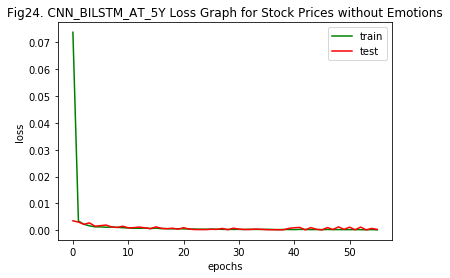

In [43]:
drawLossGraph(history_CBA5p, title='CNN_BILSTM_AT_5Y Loss Graph for Stock Prices without Emotions', num='24')

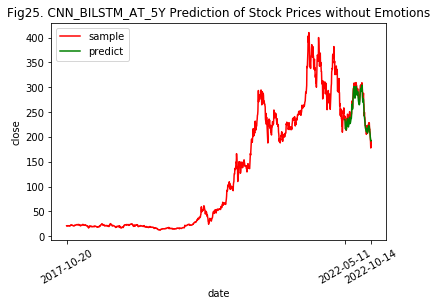

In [44]:
# 由X_test前日股票指标预测当天股票close值
# 注：predict生成的array需降维成 shape=(n_samples, )
y_predict_CBA5p = model_CBA5p.predict(X_test_CBA5p)[:,0]

# 反归一化
# 重新读取 TSLA股票价格.csv
CBA5p = pd.read_csv('file/five_year/five_result/TSLA_stockprice_5Y.csv')
col_n_CBA5p = CBA5p.shape[1]-2
# 预测结果反归一化
inv_yPredict_CBA5p = inverse_transform_col(scaler_CBA5p, y_predict_CBA5p, col_n_CBA5p)
# 真实结果反归一化
inv_yTest_CBA5p = inverse_transform_col(scaler_CBA5p, y_test_CBA5p, col_n_CBA5p)
# 训练集结果反归一化（以绘制完整图像）
inv_yTrain_CBA5p = inverse_transform_col(scaler_CBA5p, y_train_CBA5p, col_n_CBA5p)
# 绘图
predictGraph(inv_yTrain_CBA5p, inv_yPredict_CBA5p, inv_yTest_CBA5p, timelabels = CBA5p['Date'].values, title='CNN_BILSTM_AT_5Y Prediction of Stock Prices without Emotions', num='25')


In [45]:
# 输出MSE MAE R方评估值
MSE_error_CBA5p = mean_squared_error(inv_yTest_CBA5p, inv_yPredict_CBA5p)
RMSE_CBA5p = math.sqrt(MSE_error_CBA5p)
MAE_CBA5p = mean_absolute_error(inv_yTest_CBA5p, inv_yPredict_CBA5p)
R_square_CBA5p = r2_score(inv_yTest_CBA5p, inv_yPredict_CBA5p)
print('The Mean Squared Error is {}'.format(MSE_error_CBA5p))
print('The Root Mean Squared Error is:')
print(RMSE_CBA5p)
print('The Mean Absolute Error is:',MAE_CBA5p)
print('R Square is {}'.format(R_square_CBA5p))

The Mean Squared Error is 46.46836872366991
The Root Mean Squared Error is:
6.816771136224973
The Mean Absolute Error is: 6.035539613851662
R Square is 0.9614683151787466


In [46]:
print(model_CBA5p.summary())

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 20, 6)]      0                                            
__________________________________________________________________________________________________
conv1d_3 (Conv1D)               (None, 20, 128)      2432        input_4[0][0]                    
__________________________________________________________________________________________________
dropout_6 (Dropout)             (None, 20, 128)      0           conv1d_3[0][0]                   
__________________________________________________________________________________________________
bilstm (Bidirectional)          (None, 20, 256)      263168      dropout_6[0][0]                  
____________________________________________________________________________________________

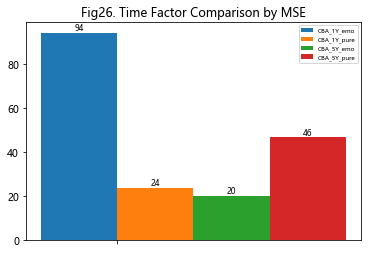

In [47]:
# 绘制CBA算法一年和五年的估值比较图
#import matplotlib
#import matplotlib.pyplot as plt
#import numpy as np

def drawHistogram_one_to_five(title, num):
    matplotlib.rc("font", family='MicroSoft YaHei')
    
    list1 = np.array([MSE_error_CBA1Emo])   # 柱状图第一组数据
    list2 = np.array([MSE_error_CBA1p])   # 柱状图第二组数据
    list3 = np.array([MSE_error_CBA5Emo])   # 柱状图第三组数据
    list4 = np.array([MSE_error_CBA5p])   # 柱状图第四组数据
    
    length = len(list1)
    x = np.arange(length)   # 横坐标范围
    x_label = [" "]

    plt.figure()
    total_width, n = 2.4 , 6   # 柱状图总宽度，有几组数据
    width = total_width / n   # 单个柱状图的宽度
    x1 = x - width / 2   # 第一组数据柱状图横坐标起始位置
    x2 = x1 + width   # 第二组数据柱状图横坐标起始位置
    x3 = 2*width + x1
    x4 = 3*width + x1
    # 标题
    plt.title('Fig'+num+'. '+title)

    plt.bar(x1, list1, width=width, label="CBA_1Y_emo")
    plt.bar(x2, list2, width=width, label="CBA_1Y_pure")
    plt.bar(x3, list3, width=width, label="CBA_5Y_emo")
    plt.bar(x4, list4, width=width, label="CBA_5Y_pure")
    
    for a, b in zip(x1, list1):
        plt.text(a, b + 0.1, '%.0f' % b, ha='center', va='bottom', fontsize=8)

    for a, b in zip(x2, list2):
        plt.text(a, b + 0.1, '%.0f' % b, ha='center', va='bottom', fontsize=8)
    
    for a, b in zip(x3, list3):
        plt.text(a, b + 0.1, '%.0f' % b, ha='center', va='bottom', fontsize=8)

    for a, b in zip(x4, list4):
        plt.text(a, b + 0.1, '%.0f' % b, ha='center', va='bottom', fontsize=8)
    

    plt.xticks(x, x_label)   
    # 给出图例
    plt.legend(loc=1, prop={'size': 6})
    
    
    # 保存于 file/
    #savingPath = 'file/Fig'+num+'_'+title.replace(' ', '_')+'.png'
    #plt.savefig(savingPath, dpi=400, bbox_inches='tight')
    plt.show()

if __name__ == '__main__':
    drawHistogram_one_to_five(title = 'Time Factor Comparison by MSE', num = '26')

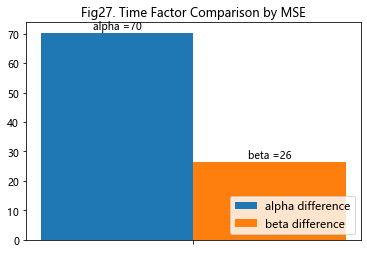

In [48]:
# 绘制CBA算法MSE差值比较图 （alpha & beta）
#import matplotlib
#import matplotlib.pyplot as plt
#import numpy as np

def difference_MSE(title, num):
    matplotlib.rc("font", family='MicroSoft YaHei')
    
    list1 = np.array([MSE_error_CBA1Emo])   # 柱状图第一组数据
    list2 = np.array([MSE_error_CBA1p])   # 柱状图第二组数据
    list3 = np.array([MSE_error_CBA5Emo])   # 柱状图第三组数据
    list4 = np.array([MSE_error_CBA5p])   # 柱状图第四组数据
    alpha = abs(list1-list2)
    beta = abs(list3-list4)
    
    length = len(list1)
    x = np.arange(length)   # 横坐标范围
    x_label = [" "]

    plt.figure()
    total_width, n = 2.4 , 6   # 柱状图总宽度，有几组数据
    width = total_width / n   # 单个柱状图的宽度
    x1 = x - width / 2   # 第一组数据柱状图横坐标起始位置
    x2 = x1 + width   # 第二组数据柱状图横坐标起始位置
    #x3 = 2*width + x1
    #x4 = 3*width + x1
    # 标题
    plt.title('Fig'+num+'. '+title)

    plt.bar(x1, alpha, width=width, label="alpha difference")
    plt.bar(x2, beta, width=width, label="beta difference")

    
    for a, b in zip(x1, alpha):
        plt.text(a, b + 0.1, 'alpha =%.0f' % b, ha='center', va='bottom', fontsize=10)

    for a, b in zip(x2, beta):
        plt.text(a, b + 0.1, 'beta =%.0f' % b, ha='center', va='bottom', fontsize=10)
    

    plt.xticks(x, x_label)   
    # 给出图例
    plt.legend(loc=4, prop={'size': 11})
    
    
    # 保存于 file/
    #savingPath = 'file/Fig'+num+'_'+title.replace(' ', '_')+'.png'
    #plt.savefig(savingPath, dpi=400, bbox_inches='tight')
    plt.show()

if __name__ == '__main__':
    difference_MSE(title = 'Time Factor Comparison by MSE', num = '27')